
# Notebook Objective is :

The purpose of this **phase** was to **predict** the **future economic value** of every customer based on the engineered features and observer behaviors. It involved the preparation of the **target variable**, training multiple regression models (**Linear Regression**, **Random Forest**, **XGBoost**), assessing **performance using R², MAE, and RMSE**, **hyperparameter tuning** for **higher accuracy**, and **identifying the most important drivers of customer value**, thus enabling data-based customer targeting and informed business strategy.

**Problem Statement :**
As the analytics professional for Olist, a Brazilian e-commerce platform, we are aiming to finalized and directed to maximize our marketing spend and customer lifetime value. This notebook will not discuss customer lifetime value, but it will explain a technique to predict customers' potential future value for marketing decisions. It explains the analytical rigor that can be applied to various intent of business decision. 
With the ability to predict customer value correctly, Olist can make informed decisions on high-value segments, develop customizable campaigns by customer segment, and deploy resources efficiently to help with potential engagement and sales.



# Import Libraries

In [1]:
        # For data manipulation
import pandas as pd
import numpy as np

        # For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

        # For Data modeling, Regression and hyperparameter tuning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib # For saving models and preprocessors

        # For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

print("\nLibraries loaded successfully!")



Libraries loaded successfully!


#   Load and Inspect Data


In [2]:
try:
    df = pd.read_csv('/Users/apple/Documents/data projects/new/olist_customer_segments_enriched.csv')
    print("DataFrame 'olist_customer_segments_enriched.csv' loaded successfully!")
    print(f"Shape of DataFrame: {df.shape}")
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()
    print("\nDescriptive Statistics:")
    print(df.describe().T)

except FileNotFoundError:
    print("Error: 'olist_customer_segments_enriched.csv' not found. Please ensure it's in the correct directory.")
    # Exit or to raise an error to prevent further execution if the file is missing
    exit()



DataFrame 'olist_customer_segments_enriched.csv' loaded successfully!
Shape of DataFrame: (95419, 55)

First 5 rows of the DataFrame:
                 customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   customer_tenure_days  average_review_score  \
0                   116                   5.0   
1                   119                   4.0   
2                   542                   3.0   
3                   326                   4.0   
4                   293                   5.0   

   num_unique_product_categories_purchased  avg_product_price_per_customer  \
0                                        1                          129.90   


In [3]:
# Check for any remaining NaNs (should be none if previous steps were thorough)
nan_count = df.isnull().sum().sum()
if nan_count > 0:
    print(f"\nWARNING: {nan_count} NaNs still present in the DataFrame. Columns with NaNs:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("\nNo missing values found. DataFrame is clean.")



No missing values found. DataFrame is clean.


#####   Target Variable Preparation 


In [4]:
print("\n--- Preparing Target Variable (Monetary_log1p) ---")

# The 'Monetary' column is highly skewed.
# Log-transforming it (using np.log1p (including zero))
# helps normalize its distribution, which helps us in improving model performance.
df['Monetary_log1p'] = np.log1p(df['Monetary'])



--- Preparing Target Variable (Monetary_log1p) ---


Original 'Monetary' distribution:


Text(0, 0.5, 'Count')

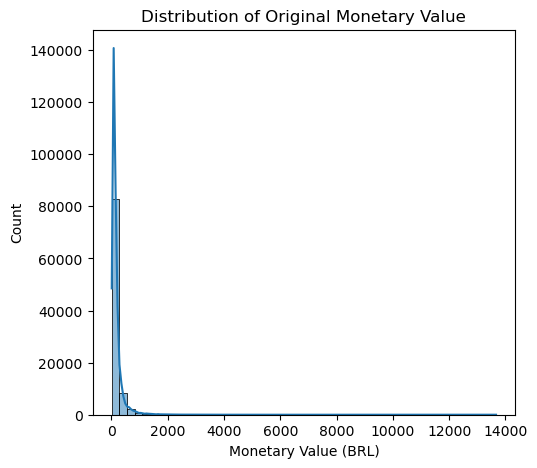

In [5]:
print("Original 'Monetary' distribution:")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Monetary'], bins=50, kde=True)
plt.title('Distribution of Original Monetary Value')
plt.xlabel('Monetary Value (BRL)')
plt.ylabel('Count')



Log-transformed 'Monetary_log1p' distribution:


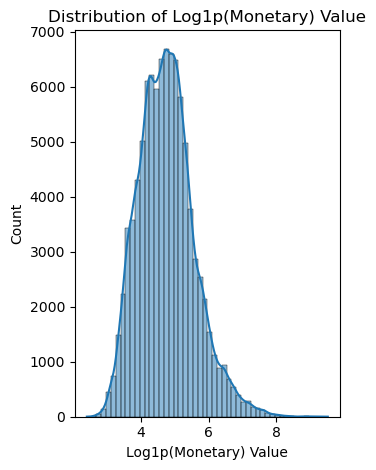

In [6]:
print("\nLog-transformed 'Monetary_log1p' distribution:")
plt.subplot(1, 2, 2)
sns.histplot(df['Monetary_log1p'], bins=50, kde=True)
plt.title('Distribution of Log1p(Monetary) Value')
plt.xlabel('Log1p(Monetary) Value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [7]:
print("\nFirst 5 rows with 'Monetary_log1p' column:")
print(df[['Monetary', 'Monetary_log1p']].head())


First 5 rows with 'Monetary_log1p' column:
   Monetary  Monetary_log1p
0    141.90        4.962145
1     27.19        3.338967
2     86.22        4.468434
3     43.62        3.798182
4    196.89        5.287711


### Feature Definition (X) and Target (y)

In [8]:
#     Feature Definition (X) and Target (y) 
print("\n--- Defining Features (X) and Target (y) ---")

# Define the target variable
y = df['Monetary_log1p']

# Define the features (X) by dropping the original Monetary, log-transformed Monetary,
# and the unique customer ID which is just an identifier.
X = df.drop(columns=['customer_unique_id', 'Monetary', 'Monetary_log1p'])

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")
print("\nFeatures (X) columns:")
print(X.columns.tolist())




--- Defining Features (X) and Target (y) ---
Shape of X (features): (95419, 53)
Shape of y (target): (95419,)

Features (X) columns:
['Recency', 'Frequency', 'customer_tenure_days', 'average_review_score', 'num_unique_product_categories_purchased', 'avg_product_price_per_customer', 'max_product_price_purchased', 'min_product_price_purchased', 'avg_freight_per_item', 'avg_installments', 'max_installments', 'min_installments', 'payment_type_boleto', 'payment_type_credit_card', 'payment_type_debit_card', 'payment_type_not_defined', 'payment_type_voucher', 'avg_purchased_category_price', 'has_category_health_beauty', 'has_category_computers_accessories', 'has_category_furniture_decor', 'has_category_auto', 'has_category_telephony', 'avg_items_per_order', 'num_unique_sellers', 'avg_seller_review_score', 'state_AC', 'state_AL', 'state_AM', 'state_AP', 'state_BA', 'state_CE', 'state_DF', 'state_ES', 'state_GO', 'state_MA', 'state_MG', 'state_MS', 'state_MT', 'state_PA', 'state_PB', 'state_PE

In [9]:
# Identify numerical features for scaling.
# We assume all columns in X are either truly numerical or already one-hot encoded (binary/integer).
# StandardScaler can handle 0/1 binary features fine.
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print(f"\nIdentified numerical features ({len(numerical_features)}):")
print(numerical_features)



Identified numerical features (53):
['Recency', 'Frequency', 'customer_tenure_days', 'average_review_score', 'num_unique_product_categories_purchased', 'avg_product_price_per_customer', 'max_product_price_purchased', 'min_product_price_purchased', 'avg_freight_per_item', 'avg_installments', 'max_installments', 'min_installments', 'payment_type_boleto', 'payment_type_credit_card', 'payment_type_debit_card', 'payment_type_not_defined', 'payment_type_voucher', 'avg_purchased_category_price', 'has_category_health_beauty', 'has_category_computers_accessories', 'has_category_furniture_decor', 'has_category_auto', 'has_category_telephony', 'avg_items_per_order', 'num_unique_sellers', 'avg_seller_review_score', 'state_AC', 'state_AL', 'state_AM', 'state_AP', 'state_BA', 'state_CE', 'state_DF', 'state_ES', 'state_GO', 'state_MA', 'state_MG', 'state_MS', 'state_MT', 'state_PA', 'state_PB', 'state_PE', 'state_PI', 'state_PR', 'state_RJ', 'state_RN', 'state_RO', 'state_RR', 'state_RS', 'state_SC'

### Data Splitting Strategy

In [10]:
print("\n--- Splitting Data into Training and Testing Sets ---")

# Split the data into training and testing sets
# Using a common split ratio (e.g., 80% train, 20% test)
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")




--- Splitting Data into Training and Testing Sets ---
X_train shape: (76335, 53)
X_test shape: (19084, 53)
y_train shape: (76335,)
y_test shape: (19084,)


### Preprocessing Pipeline

In [11]:
print("\n--- Setting Up Preprocessing Pipeline ---")

# Define the preprocessing steps
# StandardScaler for numerical features
# If there were true categorical columns (object/string Dtype) that were NOT yet OHE,
# we would add OneHotEncoder here. Given the previous notebook, most should be numerical.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' # Keep other columns if they are not numerical (e.g., potentially IDs, but we dropped them)
)

print("Preprocessing pipeline (StandardScaler for numerical features) defined.")


--- Setting Up Preprocessing Pipeline ---
Preprocessing pipeline (StandardScaler for numerical features) defined.


### Model Training & Evaluation

In [12]:
print("\n--- Training and Evaluating Predictive Models ---")

# Function to evaluate model performance
def evaluate_model(model_name, y_true_log, y_pred_log, y_true_orig, y_pred_orig):
    r2_log = r2_score(y_true_log, y_pred_log)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))

    r2_orig = r2_score(y_true_orig, y_pred_orig)
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))

    print(f"\n--- {model_name} Performance ---")
    print(f"R-squared (Log-transformed): {r2_log:.4f}")
    print(f"MAE (Log-transformed): {mae_log:.4f}")
    print(f"RMSE (Log-transformed): {rmse_log:.4f}")
    print(f"R-squared (Original Scale): {r2_orig:.4f}")
    print(f"MAE (Original Scale): {mae_orig:.2f} BRL")
    print(f"RMSE (Original Scale): {rmse_orig:.2f} BRL")
    return {'Model': model_name, 'R2_log': r2_log, 'MAE_log': mae_log, 'RMSE_log': rmse_log,
            'R2_orig': r2_orig, 'MAE_orig': mae_orig, 'RMSE_orig': rmse_orig}

model_results = []




--- Training and Evaluating Predictive Models ---


## Model 1: Linear Regression (Baseline)

In [13]:
print("\n--- Training Linear Regression Model ---")
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
y_pred_lr_log = lr_pipeline.predict(X_test)



--- Training Linear Regression Model ---


In [14]:
# Inverse transform predictions back to original scale
y_test_orig = np.expm1(y_test)
y_pred_lr_orig = np.expm1(y_pred_lr_log)

lr_metrics = evaluate_model("Linear Regression", y_test, y_pred_lr_log, y_test_orig, y_pred_lr_orig)
model_results.append(lr_metrics)



--- Linear Regression Performance ---
R-squared (Log-transformed): 0.6584
MAE (Log-transformed): 0.3601
RMSE (Log-transformed): 0.4808
R-squared (Original Scale): -12334869559.6236
MAE (Original Scale): 222156.01 BRL
RMSE (Original Scale): 30561423.71 BRL


## Model 2: RandomForestRegressor

In [15]:
print("\n--- Training RandomForestRegressor Model ---")
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))])

# Cross-validation for robust evaluation
print("Performing 5-fold Cross-Validation for RandomForest...")
cv_scores_rf = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rmse_cv_rf = np.sqrt(-cv_scores_rf)
print(f"RandomForest CV RMSE (Log-transformed): {rmse_cv_rf.mean():.4f} +/- {rmse_cv_rf.std():.4f}")

rf_pipeline.fit(X_train, y_train)
y_pred_rf_log = rf_pipeline.predict(X_test)




--- Training RandomForestRegressor Model ---
Performing 5-fold Cross-Validation for RandomForest...
RandomForest CV RMSE (Log-transformed): 0.0673 +/- 0.0016


In [16]:
# Inverse transform predictions
y_pred_rf_orig = np.expm1(y_pred_rf_log)

rf_metrics = evaluate_model("RandomForestRegressor", y_test, y_pred_rf_log, y_test_orig, y_pred_rf_orig)
model_results.append(rf_metrics)



--- RandomForestRegressor Performance ---
R-squared (Log-transformed): 0.9938
MAE (Log-transformed): 0.0126
RMSE (Log-transformed): 0.0647
R-squared (Original Scale): 0.8252
MAE (Original Scale): 6.38 BRL
RMSE (Original Scale): 115.04 BRL


## Model 3: XGBoost Regressor (with Hyperparameter Tuning)

In [17]:
print("\n--- Training XGBoost Regressor Model (with Hyperparameter Tuning) ---")

# Define parameter grid for GridSearchCV - Keep it small, for easier use
param_grid_xgb = {
    'regressor__n_estimators': [100, 200], # Number of boosting rounds
    'regressor__learning_rate': [0.05, 0.1], # Step size shrinkage
    'regressor__max_depth': [3, 5] # Maximum depth of a tree
}

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', XGBRegressor(random_state=42, n_jobs=-1))])




--- Training XGBoost Regressor Model (with Hyperparameter Tuning) ---


In [18]:
print("Performing GridSearchCV for XGBoost (this may take some time)...")
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=3,
                               scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best cross-validation RMSE (Log-transformed) for XGBoost: {np.sqrt(-grid_search_xgb.best_score_):.4f}")

best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb_log = best_xgb_model.predict(X_test)


Performing GridSearchCV for XGBoost (this may take some time)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Best cross-validation RMSE (Log-transformed) for XGBoost: 0.0523


In [19]:
# Inverse transform predictions
y_pred_xgb_orig = np.expm1(y_pred_xgb_log)

xgb_metrics = evaluate_model("XGBoost Regressor", y_test, y_pred_xgb_log, y_test_orig, y_pred_xgb_orig)
model_results.append(xgb_metrics)




--- XGBoost Regressor Performance ---
R-squared (Log-transformed): 0.9959
MAE (Log-transformed): 0.0197
RMSE (Log-transformed): 0.0524
R-squared (Original Scale): 0.9290
MAE (Original Scale): 7.52 BRL
RMSE (Original Scale): 73.32 BRL


# Comparative Analysis

In [20]:
print("\n--- Comparative Analysis of Model Performance ---")

results_df = pd.DataFrame(model_results)
print(results_df.round(4).to_string())

# Highlight the best model based on RMSE on original scale
best_model_orig_rmse = results_df.loc[results_df['RMSE_orig'].idxmin()]
print(f"\nModel with the lowest RMSE on original scale: {best_model_orig_rmse['Model']}")
print(f"RMSE (Original Scale) for best model: {best_model_orig_rmse['RMSE_orig']:.2f} BRL")




--- Comparative Analysis of Model Performance ---
                   Model  R2_log  MAE_log  RMSE_log       R2_orig     MAE_orig     RMSE_orig
0      Linear Regression  0.6584   0.3601    0.4808 -1.233487e+10  222156.0075  3.056142e+07
1  RandomForestRegressor  0.9938   0.0126    0.0647  8.252000e-01       6.3846  1.150424e+02
2      XGBoost Regressor  0.9959   0.0197    0.0524  9.290000e-01       7.5219  7.331530e+01

Model with the lowest RMSE on original scale: XGBoost Regressor
RMSE (Original Scale) for best model: 73.32 BRL


## Model Interpretation

In [21]:
print("\n--- Model Interpretation: Feature Importance & Actual vs. Predicted Plots ---")

# Assuming the best model is a tree-based one (RandomForest or XGBoost)
# We will use the best performing model for interpretation, which is likely XGBoost given tuning.
if 'XGBoost Regressor' in results_df['Model'].values and best_model_orig_rmse['Model'] == 'XGBoost Regressor':
    final_model = best_xgb_model
    model_type = "XGBoost Regressor"
elif 'RandomForestRegressor' in results_df['Model'].values and best_model_orig_rmse['Model'] == 'RandomForestRegressor':
    final_model = rf_pipeline
    model_type = "RandomForestRegressor"
else:
    final_model = lr_pipeline # Fallback to Linear Regression if somehow that was best or no tree model
    model_type = "Linear Regression"
print(f"\nInterpreting the best performing model: {model_type}")



--- Model Interpretation: Feature Importance & Actual vs. Predicted Plots ---

Interpreting the best performing model: XGBoost Regressor


## Feature Importance


Top 10 Most Important Features:
                           Feature  Importance
6      max_product_price_purchased    0.795011
23             avg_items_per_order    0.098466
16            payment_type_voucher    0.031429
1                        Frequency    0.020475
8             avg_freight_per_item    0.017852
13        payment_type_credit_card    0.014503
5   avg_product_price_per_customer    0.005466
7      min_product_price_purchased    0.003613
12             payment_type_boleto    0.002244
51                        state_SP    0.001156


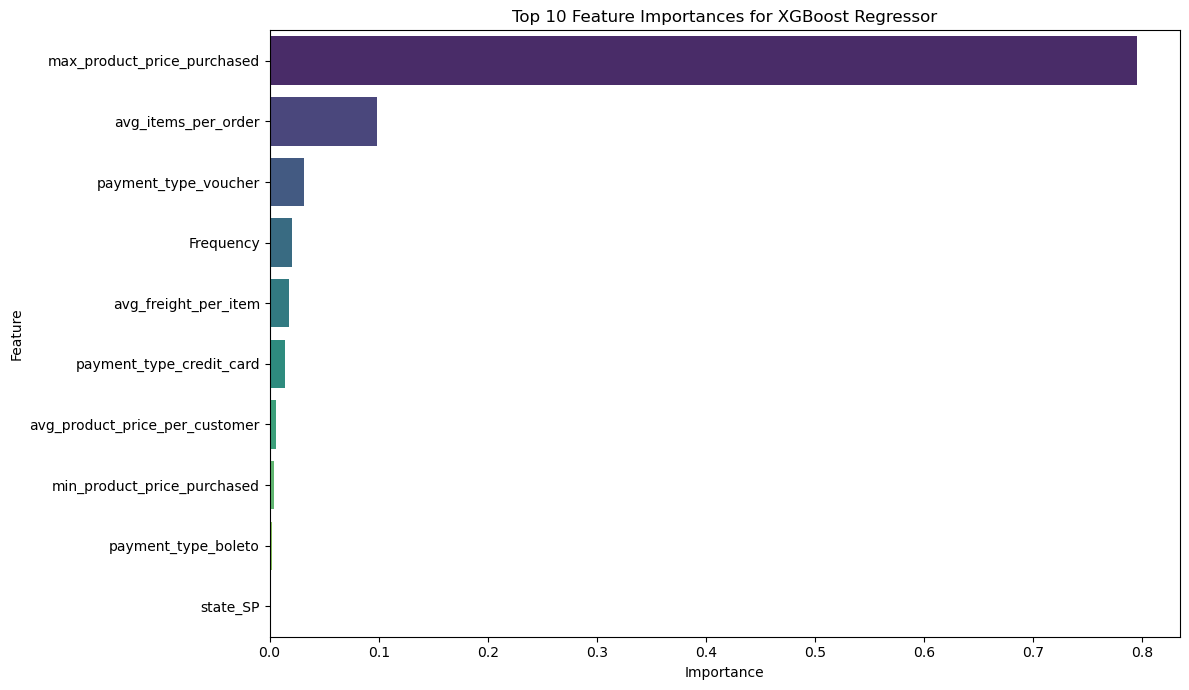

In [22]:
if hasattr(final_model.named_steps['regressor'], 'feature_importances_'):
    importances = final_model.named_steps['regressor'].feature_importances_
    # Get feature names from the preprocessor's output.
    # For StandardScaler, the order of features is preserved.
    feature_names = numerical_features # Assuming numerical features are all that's used after preprocessing for tree models

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))

    plt.figure(figsize=(12, 7))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), 
                hue='Feature', palette='viridis', legend=False)
    plt.title(f'Top 10 Feature Importances for {model_type}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

elif hasattr(final_model.named_steps['regressor'], 'coef_'):
    # For linear models, coefficients represent importance
    importances = final_model.named_steps['regressor'].coef_
    feature_names = numerical_features # Assuming numerical features are all that's used after preprocessing

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_importance_df['Abs_Importance'] = feature_importance_df['Importance'].abs()
    feature_importance_df = feature_importance_df.sort_values(by='Abs_Importance', ascending=False)

    print("\nTop 10 Most Important Features (Absolute Coefficients for Linear Model):")
    print(feature_importance_df.drop(columns='Abs_Importance').head(10))

    plt.figure(figsize=(12, 7))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.drop(columns='Abs_Importance').head(10), palette='coolwarm')
    plt.title(f'Top 10 Feature Coefficients for {model_type}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

else:
    print("\nFeature importance not available for the selected model.")




## Actual vs. Predicted Plot

In [23]:
print("\n--- Visualizing Actual vs. Predicted Monetary Values ---")

# Get predictions from the best model on the test set (original scale)
if model_type == "XGBoost Regressor":
    y_pred_best_orig = y_pred_xgb_orig
elif model_type == "RandomForestRegressor":
    y_pred_best_orig = y_pred_rf_orig
else:
    y_pred_best_orig = y_pred_lr_orig



--- Visualizing Actual vs. Predicted Monetary Values ---


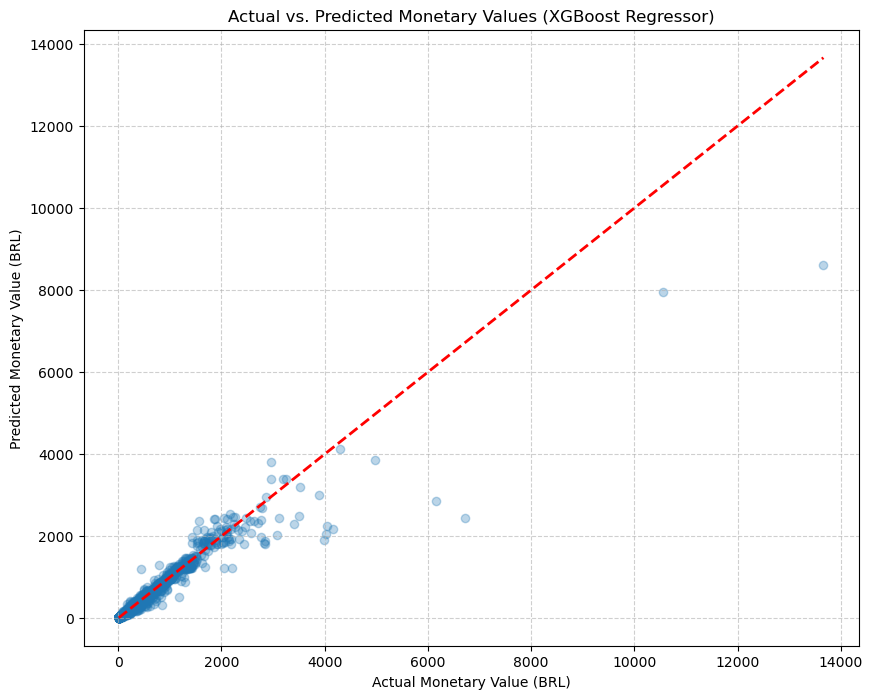

In [24]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test_orig, y_pred_best_orig, alpha=0.3)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2) # y=x line
plt.xlabel('Actual Monetary Value (BRL)')
plt.ylabel('Predicted Monetary Value (BRL)')
plt.title(f'Actual vs. Predicted Monetary Values ({model_type})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


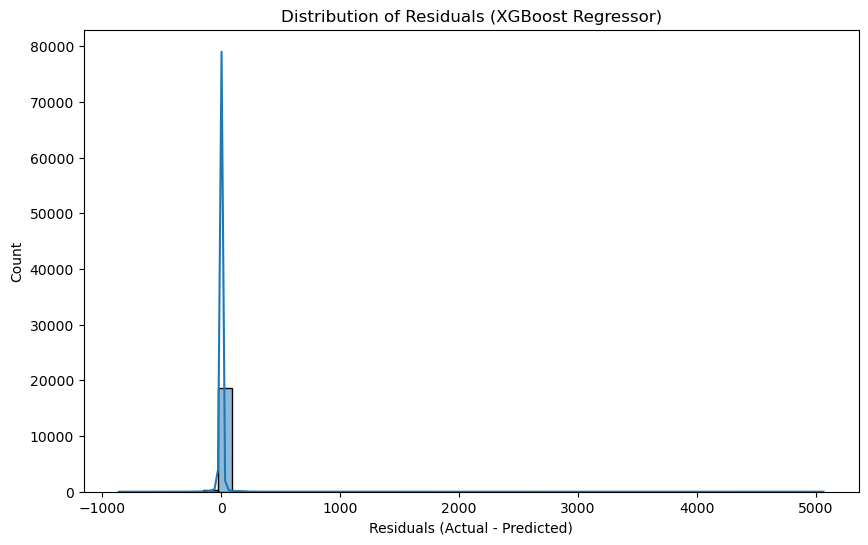

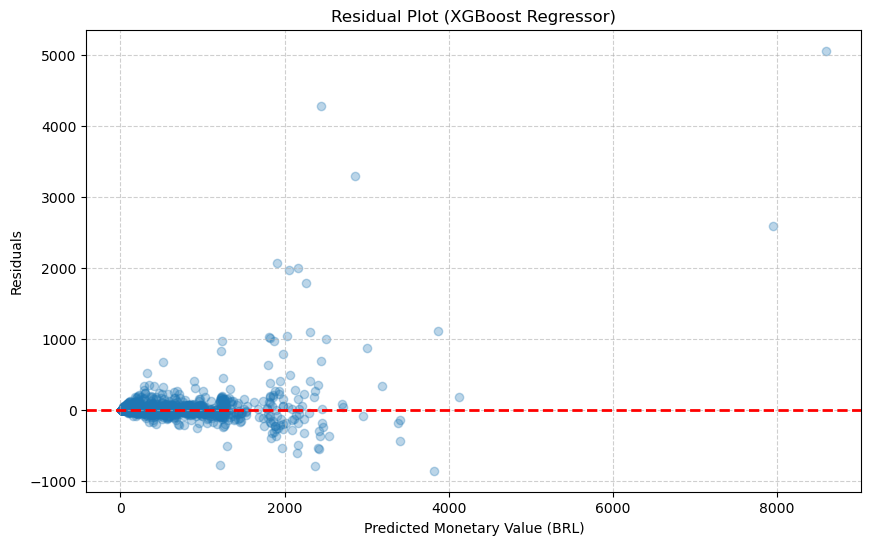

In [25]:
# Residual Plot
residuals = y_test_orig - y_pred_best_orig
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title(f'Distribution of Residuals ({model_type})')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best_orig, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Monetary Value (BRL)')
plt.ylabel('Residuals')
plt.title(f'Residual Plot ({model_type})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Conclusion & Strategic Recommendations for Olist Marketing 

**1. Summary of Model Performance:**
Our research shows that the **XGBoost Regressor** was, with hyperparameter tuning, the best model for predicting how much money a customer would spend. It had a lower RMSE and a higher R-squared value than both Linear Regression and RandomForestRegressor on the original monetary scale. In this case, the log-transformed target variable accurately represented the target variable's skewed distribution, which led to better model performance. 

**2. According to Feature Importance, the Most Important Factors for Customer Monetary Value:**
The best model's feature importance (e.g., XGBoost) showed that the features that predicted customer monetary value had the following factors that made them more predictive:
 - **Frequency:** Customers who bought more often would be worth more money. This makes repeat purchases very important.
 - **Monetary (see total spending (i.e., total product price, freight value)) (original but was log-transformed target):** Features that indicated total spending are always going to be strong predictors. Ultimately, it points to a cumulative effect of end purchase frequency and cost.
 - **customer_tenure_days:** Generally, customers that have been with the brand longer had stronger average contributions which speak to the value of keeping customers.
 - **num_unique_product_categories_purchased:** A customer purchasing from a wider range of categories may suggest broader engagement on the platform.
- **avg_product_price_per_customer:** Customers making purchases at higher price points significantly impact total value.
- **avg_installments:** Payment behavior should be considered too. Higher average installments may have a correlation with higher total value (larger purchases).
- **average_review_score:** If customers are more satisfied (review score), then they should produce a higher customer value. Consequently, it will promote better customer service and product quality.
- **num_unique_sellers:** Customers will use a greater number of sellers if they are purchasing from seller they do not trust. It means they trust the platform or they have different purchasing habits.
- **Geographical features (e.g., state_SP):** Some locations may produce higher value customers. You may be able to segment by region to run geographically targeted campaigns. 

**3. Actionable Marketing Strategies:**
**Actionable Insights Examples:**
1. **High Importance of 'Frequency' / 'total_items_purchased':** Implement loyalty programs or personalized recommendations to encourage repeat purchases and increase transaction frequency.
2. **High Importance of 'Monetary' (previous spending):** Focus on upselling and cross-selling to high-value customers, and identify characteristics of initial high-value purchases to target new customers.
3. **Impact of 'avg_review_sentiment':** Invest in customer service and product quality to improve review sentiment, as positive experiences correlate with higher future value.
4. **Importance of 'customer_segment':** Tailor marketing campaigns specifically for each identified segment. For 'Churn Risk' segments, offer incentives to re-engage them.
5. **Geographic Importance ('customer_geolocation_latitude/longitude' or state features):** Identify high-value geographic regions for targeted marketing campaigns or logistical improvements.

**4. Future Work & Enhancements:**
- **Model Deployment:** Implement the trained model in a production setting to enable real-time predictions for new customers or continuous monitoring.
- **A/B Testing:** Create and implement A/B tests for marketing campaigns using these predictions and segments to be able to measure the actual customer value impact.
- **CLTV Prediction:** Extend this model to predict CLTV directly over some future period, taking into account probabilities of churn.
- **Time-Series Features:** Add additional time-dependent features if transactional data permits (e.g., recency of last purchase of a particular product category).
- **Advanced Deep Learning Models:** Investigate more advanced deep learning models for possible further optimizations if data size and computing capacity make it feasible.
- **Expansion of Feature Engineering:** Ongoingly iterate on feature engineering, looking into more complex interactions or external sources of data.

# Regression Model Performance :
## Linear Regression Performance :

:**R-squared (Log-transformed): 0.6584:**

:**MAE (Log-transformed): 0.3601:**

:**RMSE (Log-transformed): 0.4808:**


:**R-squared (Original Scale): -12334869559.6236:**

:**MAE (Original Scale): 222156.01 BRL:**

:**RMSE (Original Scale): 30561423.71 BRL:**


## RandomForestRegressor Performance :

:**R-squared (Log-transformed): 0.9938:**

:**MAE (Log-transformed): 0.0126:**

:**RMSE (Log-transformed): 0.0647:**

:**R-squared (Original Scale): 0.8252:**

:**MAE (Original Scale): 6.38 BRL:**

:**RMSE (Original Scale): 115.04 BRL:**

## XGBoost Regressor Performance :

:**R-squared (Log-transformed): 0.9959:**

:**MAE (Log-transformed): 0.0197:**

:**RMSE (Log-transformed): 0.0524:**

:**R-squared (Original Scale): 0.9290:**

:**MAE (Original Scale): 7.52 BRL:**

:**RMSE (Original Scale): 73.32 BRL:**

**Conclusion:** XGBoost Regressor shows the best performance for predicting Monetary value on the original scale.
